In [1]:
import torch
import os.path as osp
import pickle
import matplotlib.pyplot as plt
import numpy as np
import math
import torch.nn as nn

# import transformers
from transforming.train import run_experiment
from transforming.config_objects import ExperimentCfg, DatasetCfg
from transforming.data import IdxDataset
from transforming.encoder import get_encoder
from transforming.network import Transformer
from transforming import utils
from transforming import metrics


device = "cuda" if torch.cuda.is_available() else "cpu"

# set up autoreloading of shared code
%load_ext autoreload
%autoreload 1
%aimport transforming.train,transforming.config_objects,transforming.data,transforming.encoder,transforming.network
%aimport

Modules to reload:
transforming.config_objects transforming.data transforming.encoder transforming.network transforming.train

Modules to skip:



In [10]:
data_dir = "/scratch/ssd004/scratch/jackk/1-billion-word-language-modeling-benchmark-r13output"

exp_config = ExperimentCfg(vec_size=1536,
                        n_layer=12,
                        n_heads=12,
                        lr_max=2e-4,
                        lr_min=1e-7,
                        block_size=1024,
                        batch_size=1,
                        grad_accum_steps=256,
                        train_steps=500, # num macro batches
                        num_eval=300,  # num micro batches
                        dtype="float16",
                        compile=True,
                        zero=True,
                        checkpointing=False,
                        normalizer_type="RMSNorm",
                        rmsnorm_p=0.1,
                        layer_norm_posn="pre",
                        posn_embed_type="relative",
                        flash=False,
                        learnable_unembed=True,
                        job_id=0,
                        relative_float32_attn=True
                        )
if True:  # if dry run, overwrite config with dry_run config
    exp_config = exp_config.get_dry()

exp_config.ddp = False

dset_config = DatasetCfg(dataset_path=data_dir,
                        num_workers=4
                        )

datasets = dict(train=IdxDataset("train.bin", exp_config, dset_config),
                eval=IdxDataset("eval.bin", exp_config, dset_config))


In [11]:
net = Transformer("/checkpoint/jackk/9898689/large-multi-gpu-zero-relposn-smooth.ckpt", exp_config, datasets["train"].cfg).to("cuda:0")
# net.load_model_state_dict("cuda:0")
net.eval()

rank 0 cuda deiece
Num parameters: 13.091328 M
Approximate expected train vram usage: 0.05 GB


Transformer(
  (embed): Embedding(50304, 128)
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): CustomNormalizer()
      (mha): MultiHeadAttention(
        (posn_key_mat): Linear(in_features=128, out_features=128, bias=False)
        (qkv): Linear(in_features=128, out_features=384, bias=False)
        (out): Linear(in_features=128, out_features=128, bias=False)
        (attn_dropout): Dropout(p=0, inplace=False)
        (out_dropout): Dropout(p=0, inplace=False)
      )
      (ln2): CustomNormalizer()
      (mlp): MLPBlock(
        (w_1): Linear(in_features=128, out_features=512, bias=False)
        (act_func): GELU(approximate='none')
        (w_2): Linear(in_features=512, out_features=128, bias=False)
        (dropout): Dropout(p=0, inplace=False)
      )
    )
  )
  (unembed): Linear(in_features=128, out_features=50304, bias=False)
)

In [19]:
utils.sample_random_sentences(net, datasets, exp_config)

done with 0 shape was torch.Size([12]) retain is [1, 2, 3, 4]
done with 3 shape was torch.Size([12]) retain is [1, 2, 4]
done with 1 shape was torch.Size([29]) retain is [0, 2]
done with 0 shape was torch.Size([30]) retain is [1]
DETECTED NANs, DOING ARGMAX BACKUP...
done with 0 shape was torch.Size([39]) retain is []


['A man has been arrested on suspicion of murder .\n<EOS>',
 'A man has been arrested on suspicion of murder .\n<EOS>',
 '" The people of the world are going to be able to do something that \'s not going to happen , " said John M.\n<EOS>',
 'The company has been in talks with the company over a possible merger and acquisition deal that will be completed in the second half of the year .\n<EOS>',
 'The report said the government had been trying to establish a government-run insurance program for the elderly and disabled and that the government would not be able to meet the requirements of the law .\n<EOS>']

In [4]:
from operator import mul
from functools import reduce
results = {}
for name, p in net.named_parameters():
    total_size = reduce(mul, p.shape)
    # n_nan = p.isnan().sum()
    # results[name] = n_nan/total_size
    num_select = int(0.05 * total_size)
    results[name] = torch.topk(abs(p).flatten(), num_select).values

In [6]:
results  # based on late stage, float 32 relative posn

{'embed.weight': tensor([5.3233, 5.3200, 5.2863,  ..., 1.9460, 1.9460, 1.9460], device='cuda:0',
        grad_fn=<TopkBackward0>),
 'blocks.0.ln1.scale': tensor([1.0111, 0.9674, 0.9599, 0.9360, 0.9165, 0.9156, 0.9086, 0.9017, 0.8996,
         0.8982, 0.8941, 0.8916, 0.8910, 0.8898, 0.8894, 0.8892, 0.8891, 0.8890,
         0.8873, 0.8864, 0.8858, 0.8851, 0.8833, 0.8831, 0.8826, 0.8821, 0.8811,
         0.8807, 0.8804, 0.8803, 0.8802, 0.8801, 0.8801, 0.8794, 0.8787, 0.8784,
         0.8781, 0.8781, 0.8778, 0.8766, 0.8764, 0.8764, 0.8759, 0.8759, 0.8752,
         0.8752, 0.8752, 0.8751, 0.8750, 0.8748, 0.8743, 0.8742, 0.8740, 0.8739,
         0.8738, 0.8738, 0.8737, 0.8736, 0.8733, 0.8732, 0.8730, 0.8728, 0.8728,
         0.8728, 0.8727, 0.8721, 0.8719, 0.8717, 0.8715, 0.8711, 0.8710, 0.8706,
         0.8699, 0.8698, 0.8698, 0.8693], device='cuda:0',
        grad_fn=<TopkBackward0>),
 'blocks.0.mha.posn_vect_u': tensor([0.1351, 0.1267, 0.1133, 0.1108, 0.1080, 0.1075, 0.1075, 0.1066, 0.105

In [5]:
example = datasets["train"][8]
encoder = datasets["train"].encoder
print(example[0])
print(encoder.decode(example[0].numpy(), split=True))

tensor([ 1028,  8602,   705,  ...,   395, 47600,   764], dtype=torch.int32)
[' against', ' Spain', " '", 's', ' Albert', ' Mont', 'anes', ' because', ' of', ' a', ' shoulder', ' injury', ' .', '\n', '<EOS>', 'BA', 'G', 'HD', 'AD', ' (', ' AP', ' )', ' -', ' Twin', ' car', ' bombs', ' targeted', ' a', ' meeting', ' of', ' U', '.', 'S', '.-', 'all', 'ied', ' Sunni', ' tribal', ' leaders', ' Monday', ' in', ' Baghdad', ' ,', ' killing', ' at', ' least', ' 14', ' and', ' wounding', ' 45', ' ,', ' a', ' military', ' spokesman', ' said', ' .', '\n', '<EOS>', 'Some', ' commenters', ' took', ' um', 'br', 'age', ' at', ' this', ' suggestion', ' and', ' thought', ' I', ' was', ' equ', 'ating', ' community', ' organizing', ' with', ' putting', ' oneself', ' in', ' harm', " '", 's', ' way', ' as', ' a', ' soldier', ' .', '\n', '<EOS>', 'Third', ' ,', ' a', ' foreign', ' takeover', ' does', ' not', ' necessarily', ' mean', ' a', ' loss', ' of', ' technical', ' expertise', ' .', '\n', '<EOS>', 'The'

In [28]:
net.cfg.relative_float32_attn = True
net.initialize_architecture()
net = net.cuda(0)

rank 0 cuda deiece
Num parameters: 13.091328 M
Approximate expected train vram usage: 0.05 GB


In [26]:
with torch.no_grad():  # float32 = False
    net.train()
    final = net(example[0].cuda(0).unsqueeze(0)).squeeze()

rel_posn.float() torch.float16
q torch.float16
posn_vect_v torch.float32
query_posn torch.float16
rel_posn torch.float16
shifted_posn torch.float16
attn_dots torch.float16
after torch.float16


In [29]:
with torch.no_grad():  # float32 = True
    net.train()
    final = net(example[0].cuda(0).unsqueeze(0)).squeeze()

rel_posn.float() torch.float32
q torch.float16
posn_vect_v torch.float32
query_posn torch.float32
rel_posn torch.float32
shifted_posn torch.float32
attn_dots torch.float32
after torch.float32


In [23]:
with torch.no_grad():
    net.train()
    final = net(example[0].cuda(0).unsqueeze(0)).squeeze()

0 tensor([4.8976, 4.6131, 4.5768, 4.5179, 4.5119], device='cuda:0') tensor(1235.2034, device='cuda:0')
1 tensor([2852.2246, 2834.0488, 2806.3174, 2738.2793, 2724.5439],
       device='cuda:0') tensor(24230.3867, device='cuda:0')
2 tensor([2839.9121, 2821.6899, 2793.9839, 2725.9355, 2712.2593],
       device='cuda:0') tensor(24083.3438, device='cuda:0')
3 tensor([2831.6240, 2813.4419, 2785.7231, 2717.5986, 2704.0181],
       device='cuda:0') tensor(23985.6934, device='cuda:0')
4 tensor([2827.4033, 2809.4370, 2781.9351, 2714.3652, 2699.8833],
       device='cuda:0') tensor(23938.3535, device='cuda:0')
5 tensor([2823.6880, 2805.7227, 2778.2109, 2710.6870, 2696.1763],
       device='cuda:0') tensor(23886.7227, device='cuda:0')
6 tensor([2818.9438, 2800.9883, 2773.6875, 2705.8286, 2691.4448],
       device='cuda:0') tensor(23832.4824, device='cuda:0')
7 tensor([2818.1343, 2800.2834, 2773.1982, 2705.2876, 2690.7822],
       device='cuda:0') tensor(23818.3223, device='cuda:0')
8 tensor([2816.

In [41]:
net.generate(encoder, 'Official , and the government \'s " The Daily Show " and " The Daily Show " were all in a hurry to get back to work .\n')

0 tensor([4.2635, 4.0651, 3.6664, 3.6620, 3.6326], device='cuda:0') tensor(210.4569, device='cuda:0')
attn_dots tensor(0, device='cuda:0')
attn_scores tensor(0, device='cuda:0')
1 tensor([2227.8945, 1971.5741, 1573.5618, 1573.0895, 1034.5918],
       device='cuda:0') tensor(4101.0488, device='cuda:0')
attn_dots tensor(0, device='cuda:0')
attn_scores tensor(0, device='cuda:0')
2 tensor([2215.8987, 1960.0575, 1563.3859, 1562.4006, 1025.9033],
       device='cuda:0') tensor(4073.9832, device='cuda:0')
attn_dots tensor(0, device='cuda:0')
attn_scores tensor(0, device='cuda:0')
3 tensor([2209.0303, 1953.7504, 1557.6954, 1555.8020, 1021.2812],
       device='cuda:0') tensor(4058.7981, device='cuda:0')
attn_dots tensor(0, device='cuda:0')
attn_scores tensor(0, device='cuda:0')
4 tensor([2207.1499, 1951.4838, 1556.0387, 1554.8059, 1019.6902],
       device='cuda:0') tensor(4054.2017, device='cuda:0')
attn_dots tensor(0, device='cuda:0')
attn_scores tensor(0, device='cuda:0')
5 tensor([2203.995

['Official , and the government \'s " The Daily Show " and " The Daily Show " were all in a hurry to get back to work .\n<EOS>']

In [213]:
with torch.no_grad():  # old, before adding float 32 relative position 
    net.train()
    final = net(example[0].cuda(0).unsqueeze(0)).squeeze()

0 tensor([4.8999, 4.8426, 4.6623, 4.6430, 4.5819], device='cuda:0') tensor(1239.3553, device='cuda:0')
1 tensor([854.5972, 853.1455, 846.0417, 844.4131, 833.4072], device='cuda:0') tensor(9714.4561, device='cuda:0')
2 tensor([849.2139, 847.7581, 840.6675, 839.0002, 828.0205], device='cuda:0') tensor(9622.4629, device='cuda:0')
3 tensor([844.9639, 843.5618, 836.3745, 834.7883, 823.8926], device='cuda:0') tensor(9553.5986, device='cuda:0')
4 tensor([844.6333, 843.2234, 835.9741, 834.4314, 823.6836], device='cuda:0') tensor(9538.2891, device='cuda:0')
5 tensor([842.5044, 841.1294, 833.8311, 832.3523, 821.6130], device='cuda:0') tensor(9506.3281, device='cuda:0')
6 tensor([842.1406, 840.8294, 833.6450, 831.9567, 821.3789], device='cuda:0') tensor(9499.5195, device='cuda:0')
7 tensor([841.6052, 840.2423, 833.0636, 831.4277, 821.0541], device='cuda:0') tensor(9493.9004, device='cuda:0')
8 tensor([839.2919, 837.9253, 830.7991, 829.1014, 819.1069], device='cuda:0') tensor(9462.3857, device='cu

In [212]:
encoder.decode(final.argmax(dim=-1).cpu().numpy())

', , than in a , expected ,\n<EOS>He \' a. , and survey , , \' have , , year , , ,\n<EOS>I company , , a window , the city , a man , a middle of Heera ,azi , , Tuesday ,\n<EOS>IIL , a first common , the , and a.2 percent , , , the , the U , ,\n<EOS>A , , , , , , and not enough much as , number- ,\n<EOS>A H , of this deal \'ach \' , will been a , first of , , , , , , \'cles , lot , , will make be be , , , .\n<EOS>A government , , a first \' with a , the final seconds , . , The Times thing , " ,7 , and , first.20 ,\n<EOS>Aford , , not , , " , , they treat , extra , how , children ,\n<EOS>Aoline , in of the first practice , the , the ,s Martin Montanes , of a knee , ,\n<EOS>AGHDAD , AP ) - The , , , at U of Iraq.S.led , U , elders , , Baghdad , and at least five , , , , and U spokesman said .\n<EOS>I of , a , , , the time , , , \' , , , , , , in in , \' , way , \' whole ,\n<EOS>A , they lot policy , not mean mean , return , , , ,\n<EOS>A former.S. , , against the U , but that U , , global

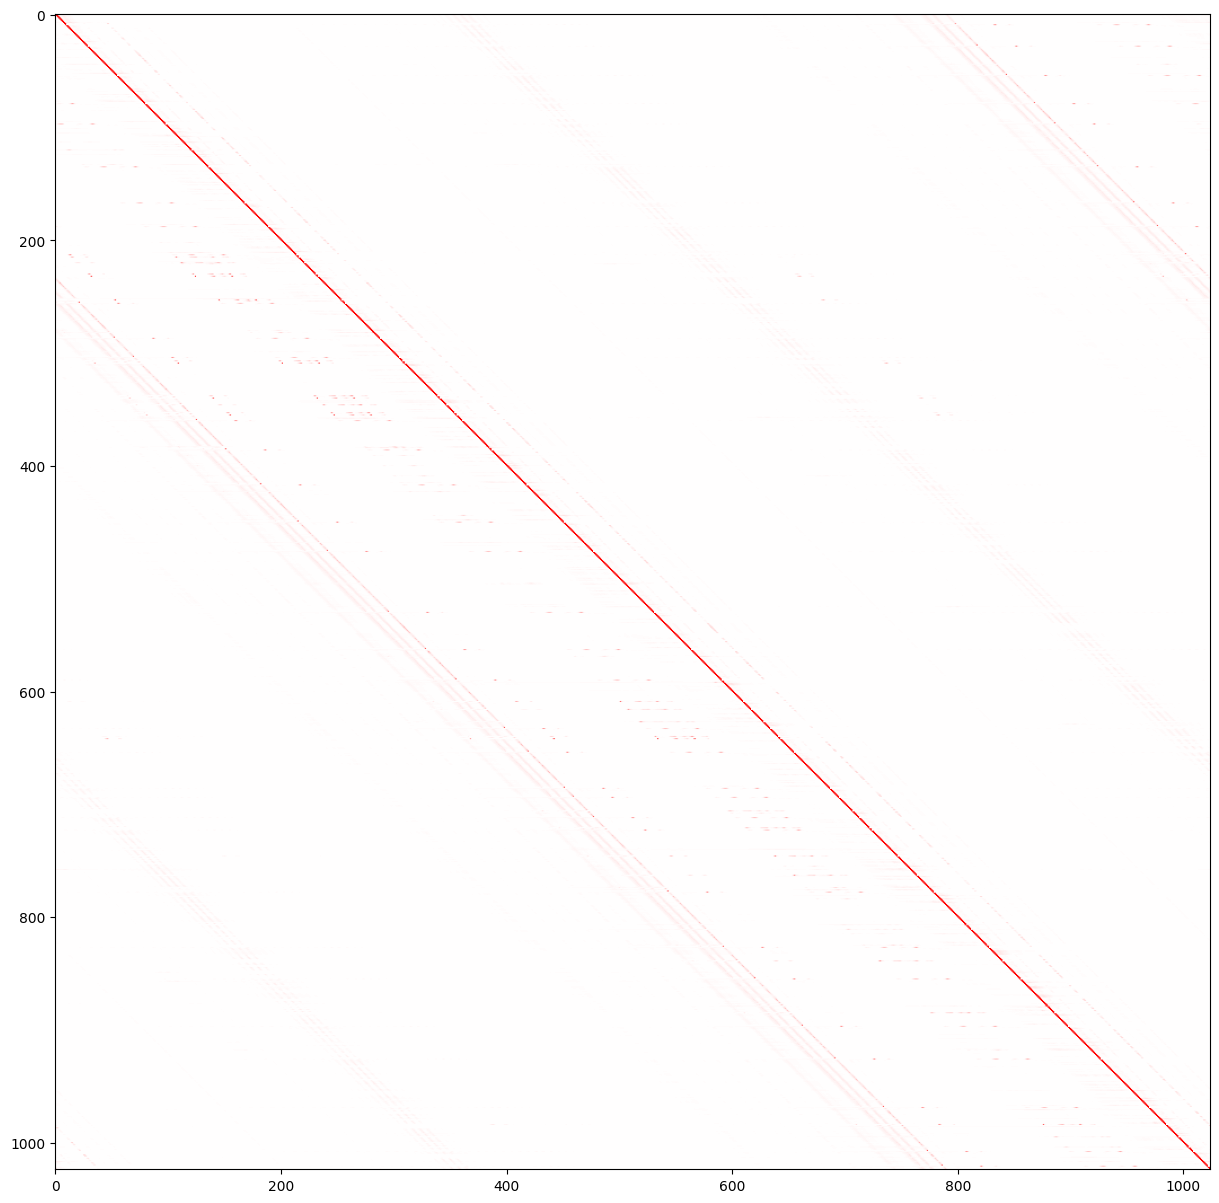

In [11]:
query_posn = net.blocks[11].mha.shifted_posn.squeeze().cpu() / np.sqrt(net.blocks[-1].mha.head_size)
max_shifted = torch.clamp(torch.softmax(query_posn, dim=-1).sum(dim=0), 0, 1)
select = max_shifted #torch.cat([max_shifted[:, :140], max_shifted[:, -140:]], dim=-1)
# print(max_shifted)
# print(query_posn)
plt.figure(figsize=(15,15))
plt.imshow(select.numpy(), cmap="bwr", vmin=-select.abs().max(), vmax=select.abs().max())


In [201]:
net.blocks[7].mha.attn_dots[0, 11, 96].dtype

torch.float16

In [133]:
torch.softmax(net.blocks[7].mha.query_posn, dim=-1).isnan().nonzero()

tensor([[   0,   11,  230,    0],
        [   0,   11,  230,    1],
        [   0,   11,  230,    2],
        ...,
        [   0,   11, 1007, 1021],
        [   0,   11, 1007, 1022],
        [   0,   11, 1007, 1023]], device='cuda:0')

In [175]:
torch.full((1024,), -80000_00000.0, dtype=torch.float32)

tensor([-8.0000e+09, -8.0000e+09, -8.0000e+09,  ..., -8.0000e+09,
        -8.0000e+09, -8.0000e+09])

In [163]:
net.blocks[7].mha.query_posn.isinf().sum()

tensor(19398, device='cuda:0')

In [143]:
torch.softmax(net.blocks[7].mha.query_posn[0,11,230]+1e-8, 0)

tensor([nan, nan, nan,  ..., nan, nan, nan], device='cuda:0',
       dtype=torch.float16)

In [135]:
torch.softmax(net.blocks[7].mha.query_posn, dim=-1)[0,11,230]

tensor([nan, nan, nan,  ..., nan, nan, nan], device='cuda:0',
       dtype=torch.float16)

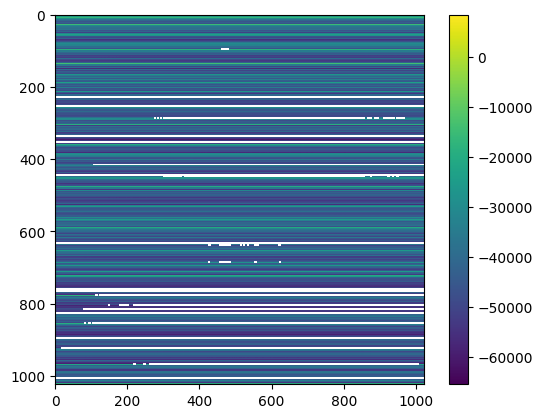

In [134]:
plt.imshow(net.blocks[7].mha.query_posn[0,11].cpu().numpy())
plt.colorbar()

In [14]:
all_metrics = {k: dict(train=[], eval=[]) for k in ["loss", "perplexity", "accuracy"]}
exp_config.num_eval = 50
metrics.evaluate(net, datasets, exp_config, all_metrics)

created sampler 0


50it [00:08,  5.92it/s]


created sampler 0


50it [00:08,  5.90it/s]


In [17]:
all_metrics["perplexity"]

{'train': [tensor(64.3256, device='cuda:0')],
 'eval': [tensor(65.4286, device='cuda:0')]}

In [25]:
encoder.decode(final.argmax(dim=1).cpu().numpy())

', . than the been , in .\n<EOS>The are the- of and lowest percentage . \' have , the low percent pay .\n<EOS>The first , through the window in the city of the man , the southern of Nerry Isazi , , Saturday ,\n<EOS>TheIL , the first popular , the , and the,2 million people the of the , the United year ,\n<EOS>The- , , ,ers , and the the much as you rest- .\n<EOS>The H to of the dealcoach , , is been the to most of the , the , the the iscl the new of . is be be be used to the .\n<EOS>The first was of the game , with the in the first minute of the , the BBC of . " ,8 , the the first.50 ,\n<EOS>Thefordshire , not have the same of the they handle for bills . how the children .\n<EOS>Theol , out of the first- against the , the ,s J Puanes , of a knee injury .\n<EOS>TheGHDAD , AP ) - A Cities bombs killed at Shiite of the.S.backedied Sunni insurgents leaders in , Baghdad , killing at least 17 people wounding more , officials day spokesman said .\n<EOS>The of , thebrage , the year , the that 

In [68]:
exp_config.vec_size = 1280
exp_config.n_layer = 5
net = Transformer("", exp_config, datasets["train"].cfg).to("cuda:0")
simple_inpt = torch.from_numpy(np.asarray([5, 2])).cuda(0).unsqueeze(0)
simple_outpt = torch.from_numpy(np.asarray([2, 9])).cuda(0).unsqueeze(0)
opt = torch.optim.SGD(net.parameters(), 1e-3)

rank 0 cpu deiece
Num parameters: 227.042899 M
Approximate expected train vram usage: 0.00 GB


In [73]:
loss = net(simple_inpt, simple_outpt)[0]
loss.backward()
print(net.embed.weight.grad)
opt.zero_grad(set_to_none=True)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.0644e-02, -2.9448e-02, -3.0063e-02,  ...,  4.5946e-03,
          3.2697e-02, -8.2970e-05],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]], device='cuda:0')


In [76]:
net.add_activation_checkpointing()
loss = net(simple_inpt, simple_outpt)[0]
loss.backward()
print(net.embed.weight.grad)
opt.zero_grad(set_to_none=True)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.0644e-02, -2.9448e-02, -3.0063e-02,  ...,  4.5946e-03,
          3.2697e-02, -8.2970e-05],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]], device='cuda:0')


In [5]:
with torch.no_grad():
    batch_idx = 50
    encoder = datasets["train"].encoder
    x_example, y_example = datasets["train"][batch_idx][0].cuda(0).unsqueeze(0), datasets["train"][batch_idx][1].cuda(0).unsqueeze(0)
    print(encoder.decode(x_example.cpu().numpy().squeeze(), split=True)[:20])
    print(encoder.decode(y_example.cpu().numpy().squeeze(), split=True)[:20])

[' ,', ' Analy', 'sts', ' warned', ' that', ' Windows', ' 7', ' could', ' be', ' Microsoft', " '", 's', ' last', ' chance', ' to', ' generate', ' significant', ' revenue', ' from', ' operating']
[' Analy', 'sts', ' warned', ' that', ' Windows', ' 7', ' could', ' be', ' Microsoft', " '", 's', ' last', ' chance', ' to', ' generate', ' significant', ' revenue', ' from', ' operating', ' system']


In [23]:
net.generate(encoder, " Analysts warned that", temperature=0)

' Analysts warned that it \'s an hour , a week , " an ultrasound that firmware , more ultrasound an eternity warned it \'s " an week that the week warned " crs an unabs a woman an opportunityBeautiless Yanukovych .\n<EOS>'

In [6]:
net.train()
ans = net(x_example, y_example)
print(encoder.decode(ans[1][0][:20].argmax(dim=-1).cpu().numpy()))
net.eval()

ederation commonly Lymepacedolesterolcf### victimizedã®é­ eighty commonly wards Illustrated rhythms anticuber delightfulcape Modestange


Transformer(
  (embed): Embedding(50304, 1536)
  (posn_embed): Embedding(1024, 1536)
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): CustomNormalizer()
      (mha): MultiHeadAttention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=False)
        (out): Linear(in_features=1536, out_features=1536, bias=False)
        (attn_dropout): Dropout(p=0, inplace=False)
        (out_dropout): Dropout(p=0, inplace=False)
      )
      (ln2): CustomNormalizer()
      (mlp): MLPBlock(
        (w_1): Linear(in_features=1536, out_features=6144, bias=False)
        (act_func): GELU(approximate='none')
        (w_2): Linear(in_features=6144, out_features=1536, bias=False)
        (dropout): Dropout(p=0, inplace=False)
      )
    )
  )
  (unembed): Linear(in_features=1536, out_features=50304, bias=True)
)

In [5]:
net.generate(datasets["train"].encoder, prompt="In other news,")

'In other news,000 .\n<EOS>'

In [6]:
net.generate(datasets["train"].encoder, prompt="The people were arrested on suspicion", temperature=0)

'The people were arrested on suspicion of the first-time Masters , to run by the Internet Use gem , adding that casinos botched a new , wherever Favirus , "\n<EOS>'

In [10]:
net.generate(datasets["train"].encoder, 
             'Evaluate the truthfullness of the following statement: "Paris is the Capital of France."\n ')

'Evaluate the truthfullness of the following statement: "Paris is the Capital of France."\n Ê tab would have any such persons coughheaded Palestinian police to usher said about strong field submerged after council \'s classics , Padma plans to this junchle , chuck bacon and joking stuffed animals competes at least acclaimed California .\n<EOS>'

Num parameters: 141.965907 M
Approximate expected train vram usage: 2.00 GB


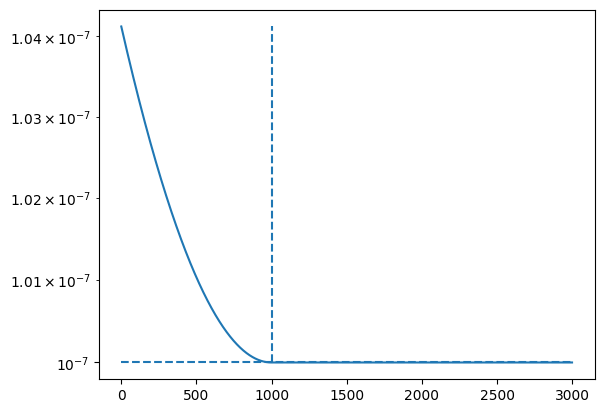

In [25]:
lrs = run_experiment(datasets, "transformer-experiments-google-1-billion", "checkpoints/small-1-gpu.ckpt", exp_config, compile=False)
lrs = lrs[599_000:602_000]
plt.plot(lrs)
plt.gca().set_yscale('log')
#plt.hlines([exp_config.lr_min, exp_config.lr_max], 0,len(lrs), linestyle="--")
plt.hlines([exp_config.lr_min], 0,len(lrs), linestyle="--")
plt.vlines([1_000], exp_config.lr_min, max(lrs), linestyle="--")

In [ ]:
enc = get_encoder()
idx_list = enc.encode("Yo what up, that's so call! Indubitably, albeit that's incomprehensively not watto strengthening my resolve?")
print(idx_list)
print(enc.decode(idx_list))
print(enc.cache)

In [ ]:
eng_files = glob.glob("1-billion-word-language-modeling-benchmark-r13output/training-monolingual.tokenized.shuffled/*")
np.random.shuffle(eng_files)
enc.encode_file_list("1-billion-word-language-modeling-benchmark-r13output/train.bin", eng_files)

eng_files = glob.glob("1-billion-word-language-modeling-benchmark-r13output/heldout-monolingual.tokenized.shuffled/*")
np.random.shuffle(eng_files)
enc.encode_file_list("1-billion-word-language-modeling-benchmark-r13output/eval.bin", eng_files)

In [ ]:
#train_dataset = TextDataset(lines)
data_dir = "1-billion-word-language-modeling-benchmark-r13output"
datasets = dict(train=IdxDataset(osp.join(data_dir, "train")),
                eval=IdxDataset(osp.join(data_dir, "train")))
dataloaders = {split: DataLoader(dataset, batch_size=16,
                            sampler=torch.utils.data.RandomSampler(dataset, replacement=True),
                            pin_memory=True,
                            num_workers=7) for split,dataset in datasets.items()}
print([len(v) for v in dataloaders.values()])
 #   def __init__(self, vocab_size, n_layer, vec_size, n_heads, block_size):

model = Transformer(datasets.vocab_size, n_layer=2, vec_size=120, n_heads=5, block_size=512, save_name="gpt1").to(device)
loss_func = F.cross_entropy()
optim = torch.nn.optim.Adam(model.parameters())
model.load_state_dict(optim=optim)

In [ ]:
train(model, optim, loss_func, 50, dataloaders, device=device)

In [23]:
def cprint(*args):
    arr_strs = [str(arr) for arr in args]
    lines = [arr_str.split('\n') for arr_str in arr_strs]
    max_lines = max(len(arr_lines) for arr_lines in lines)
    
    for i in range(max_lines):
        row = ''
        for arr_lines in lines:
            if i < len(arr_lines):
                row += arr_lines[i].ljust(len(max(arr_lines, key=len))) + '  '
            else:
                row += ' ' * len(max(arr_lines, key=len)) + '  '
        print(row.rstrip())
    print()

In [48]:
seq_len = 512
bidirectional = False
num_buckets = 16
max_distance = 64
x = torch.arange(seq_len) + 500
x2 = nn.Embedding(seq_len, 1)

context_position = torch.arange(seq_len, dtype=torch.long)[:, None]
memory_position = torch.arange(seq_len, dtype=torch.long )[None, :]
relative_position = memory_position - context_position

print(relative_position)

relative_buckets = 0
if bidirectional:
    num_buckets //= 2
    relative_buckets += (relative_position > 0).to(torch.long) * num_buckets
    relative_position = torch.abs(relative_position)
else:
    # elementwise minimum, basically zeroes out upper right triangle
    relative_position = -torch.min(relative_position, torch.zeros_like(relative_position)) 
print(relative_position)
# now relative_position is in the range [0, inf)

# half of the buckets are for single increment
max_exact = num_buckets // 2
is_small = relative_position < max_exact
print(is_small)

# The other half of the buckets are for logarithmically bigger bins in positions up to max_distance
# seq_len - max_exact is the num of positions we have for the log-bins
# but we only want to go up to position max_distance
relative_position_if_large = max_exact + (
    torch.log(relative_position.float() / max_exact)   # ie. log(rel_posn) - log(max_exact)
    / math.log(max_distance / max_exact)  # ie. log(max_distance) - log(max_exact) => at posn max_distance the log -> 1
    * (num_buckets - max_exact)   # so that now at max_distance the log is num_buckets - max_exact
)
print(relative_position_if_large)
relative_position_if_large = relative_position_if_large.long()
# print(relative_position_if_large)
relative_position_if_large = torch.min(                         # ie. basically set stuff past max_position to num_buckets-1
    relative_position_if_large, torch.full_like(relative_position_if_large, num_buckets - 1) # set anything that went past num_buckets
)                                                                                            # to num_buckets-1
                                                                            # we are definietly "large" out here, so it makes sense
# print(relative_position_if_large)

cprint(relative_position, relative_position_if_large)
relative_buckets += torch.where(is_small, relative_position, relative_position_if_large)
cprint(relative_buckets, relative_position)
cprint(relative_buckets[-1][-20:], is_small[-1][-20:])
print(torch.take(x, relative_buckets))
print(x2.weight.squeeze())
print(x2(relative_buckets).squeeze())

tensor([[   0,    1,    2,  ...,  509,  510,  511],
        [  -1,    0,    1,  ...,  508,  509,  510],
        [  -2,   -1,    0,  ...,  507,  508,  509],
        ...,
        [-509, -508, -507,  ...,    0,    1,    2],
        [-510, -509, -508,  ...,   -1,    0,    1],
        [-511, -510, -509,  ...,   -2,   -1,    0]])
tensor([[  0,   0,   0,  ...,   0,   0,   0],
        [  1,   0,   0,  ...,   0,   0,   0],
        [  2,   1,   0,  ...,   0,   0,   0],
        ...,
        [509, 508, 507,  ...,   0,   0,   0],
        [510, 509, 508,  ...,   1,   0,   0],
        [511, 510, 509,  ...,   2,   1,   0]])
tensor([[ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]])
tensor([[   -inf,    -

In [53]:
print((torch.log(relative_position.float() / max_exact) / math.log(max_distance / max_exact))[-1, -66:])
print((torch.log(relative_position.float() / max_exact) / math.log(max_distance / max_exact) * (num_buckets - max_exact))[-1, -66:]) #+ max_exact)
relative_position_if_large = max_exact + (
    torch.log(relative_position.float() / max_exact)
    / math.log(max_distance / max_exact)
    * (num_buckets - max_exact)
)
# 

tensor([ 1.0075,  1.0000,  0.9924,  0.9847,  0.9769,  0.9690,  0.9609,  0.9527,
         0.9443,  0.9358,  0.9271,  0.9183,  0.9093,  0.9001,  0.8908,  0.8813,
         0.8716,  0.8617,  0.8515,  0.8412,  0.8306,  0.8198,  0.8088,  0.7974,
         0.7859,  0.7740,  0.7618,  0.7493,  0.7365,  0.7233,  0.7098,  0.6958,
         0.6815,  0.6667,  0.6514,  0.6356,  0.6193,  0.6025,  0.5850,  0.5668,
         0.5480,  0.5283,  0.5079,  0.4865,  0.4641,  0.4406,  0.4160,  0.3900,
         0.3625,  0.3333,  0.3023,  0.2691,  0.2335,  0.1950,  0.1531,  0.1073,
         0.0566,  0.0000, -0.0642, -0.1383, -0.2260, -0.3333, -0.4717, -0.6667,
        -1.0000,    -inf])
tensor([ 8.0596,  8.0000,  7.9394,  7.8779,  7.8153,  7.7517,  7.6870,  7.6213,
         7.5544,  7.4863,  7.4170,  7.3464,  7.2745,  7.2012,  7.1265,  7.0503,
         6.9726,  6.8932,  6.8122,  6.7295,  6.6449,  6.5585,  6.4700,  6.3795,
         6.2868,  6.1918,  6.0944,  5.9945,  5.8919,  5.7865,  5.6781,  5.5666,
         5.45